In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quantstats as qs
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

from quant.utils.cointegraion import do_adf_regression, do_aeg_regression
from quant.mean_reverting.stock_pair.positions import calculate_positions_from_lambda

# Константы
ticker1 = 'CFG'
ticker2 = 'TFC'

open_threshold = 0.75
close_threshold = 0.25

oneway_trans_cost=0.0005

tickers = pd.read_parquet('../../../../data/sp500_stocks.parquet')
tickers.set_index('ticker', inplace=True)

history = pd.read_parquet('../../../../data/sp500_2023-01-01_2025-01-01.parquet')['Adj Close']
live = pd.read_parquet('../../../../data/sp500_2025-01-01_2025-07-01.parquet')['Adj Close']

history = pd.concat([history, live], axis=0)

training_start_date = '2023-01-01'
training_end_date = '2024-01-01'
training_set = history[[ticker1, ticker2]].loc[training_start_date:training_end_date].copy()

sample_start_date = '2024-01-02'
sample_end_date = '2025-01-01'
sample_set = history[[ticker1, ticker2]].loc[sample_start_date:sample_end_date].copy()

out_of_sample_start_date = '2025-01-02'
out_of_sample_end_date = '2025-07-01'
out_of_sample_set = history[[ticker1, ticker2]].loc[out_of_sample_start_date:out_of_sample_end_date].copy()

### Отобразим цены

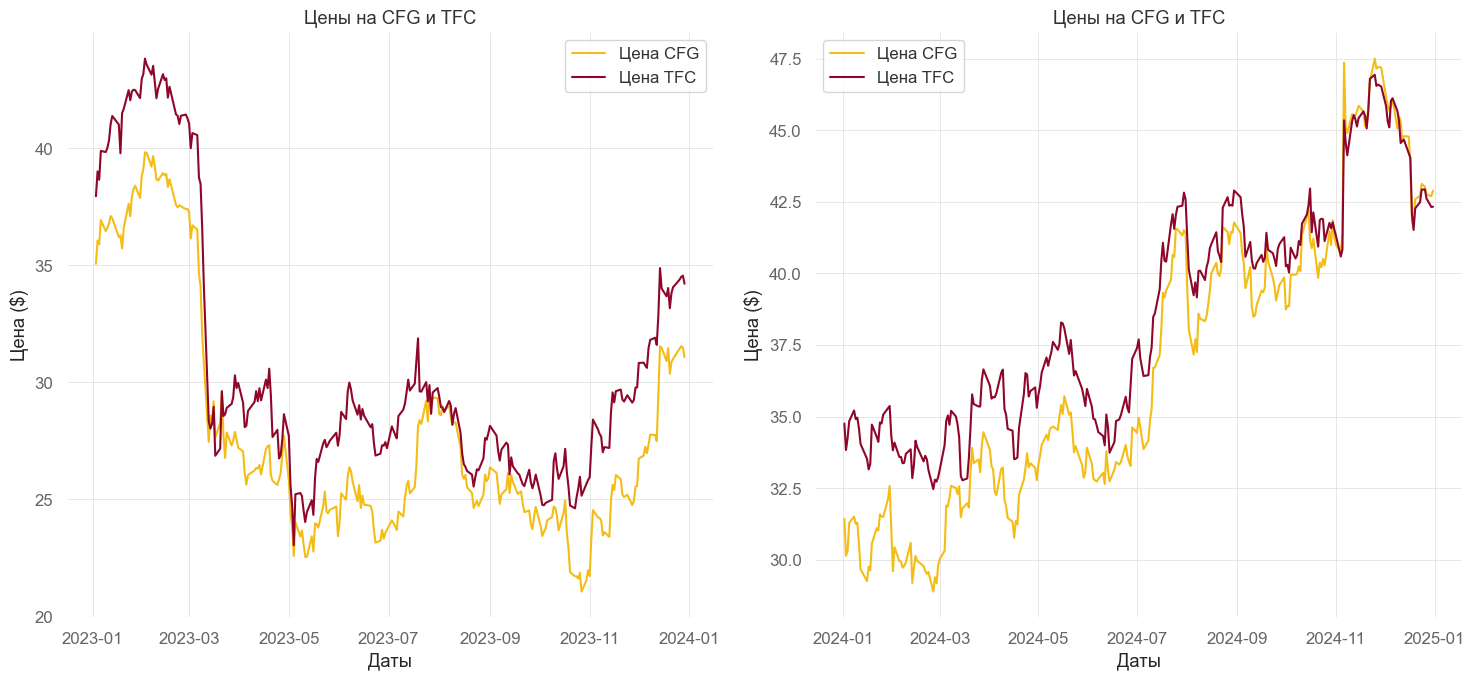

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].plot(training_set[ticker1], lw=1.5, label=f"Цена {ticker1}",color="#F4BD16")
axes[0].plot(training_set[ticker2], lw=1.5, label=f"Цена {ticker2}",color="#8E062A")
axes[0].grid(True)
axes[0].legend(loc=0)
axes[0].set_xlabel('Даты')
axes[0].set_ylabel('Цена ($)')
axes[0].set_title(f"Цены на {ticker1} и {ticker2}")

axes[1].plot(sample_set[ticker1], lw=1.5, label=f"Цена {ticker1}",color="#F4BD16")
axes[1].plot(sample_set[ticker2], lw=1.5, label=f"Цена {ticker2}",color="#8E062A")
axes[1].grid(True)
axes[1].legend(loc=0)
axes[1].set_xlabel('Даты')
axes[1].set_ylabel('Цена ($)')
axes[1].set_title(f"Цены на {ticker1} и {ticker2}")

plt.tight_layout()
plt.show()

### Проверим коинтеграцию цен
Для этого мы посчитаем корреляцию, коинтеграция по Augmented Dickey-Fuller и коинтеграция по Augmented Engle-Granger.

In [38]:
# Correlation
correlation_coef = np.corrcoef(training_set[ticker1], training_set[ticker2])[0, 1]
adf_probability = do_adf_regression(training_set, ticker1, ticker2)
aeg_probability = do_aeg_regression(training_set, ticker1, ticker2)

print(f"Корреляция между {ticker1} и {ticker2}: {correlation_coef:.2f}")
print(f"Вероятность коинтеграции по ADF: {adf_probability:.1f}")
print(f"Вероятность коинтеграции по AEG: {aeg_probability:.1f}")

sample_correlation_coef = np.corrcoef(sample_set[ticker1], sample_set[ticker2])[0, 1]
sample_adf_probability = do_adf_regression(sample_set, ticker1, ticker2)
sample_aeg_probability = do_aeg_regression(sample_set, ticker1, ticker2)

print(f"Sample: Корреляция между {ticker1} и {ticker2}: {sample_correlation_coef:.2f}")
print(f"Sample: Вероятность коинтеграции по ADF: {sample_adf_probability:.1f}")
print(f"Sample: Вероятность коинтеграции по AEG: {sample_aeg_probability:.1f}")

Корреляция между CFG и TFC: 0.97
Вероятность коинтеграции по ADF: 95.0
Вероятность коинтеграции по AEG: nan
Sample: Корреляция между CFG и TFC: 0.99
Sample: Вероятность коинтеграции по ADF: 99.0
Sample: Вероятность коинтеграции по AEG: 99.0


### Используем Kalman Filter для расчета параметров

Мы будем использовать Kalman Filter для расчета hedge ratio, mean and std.

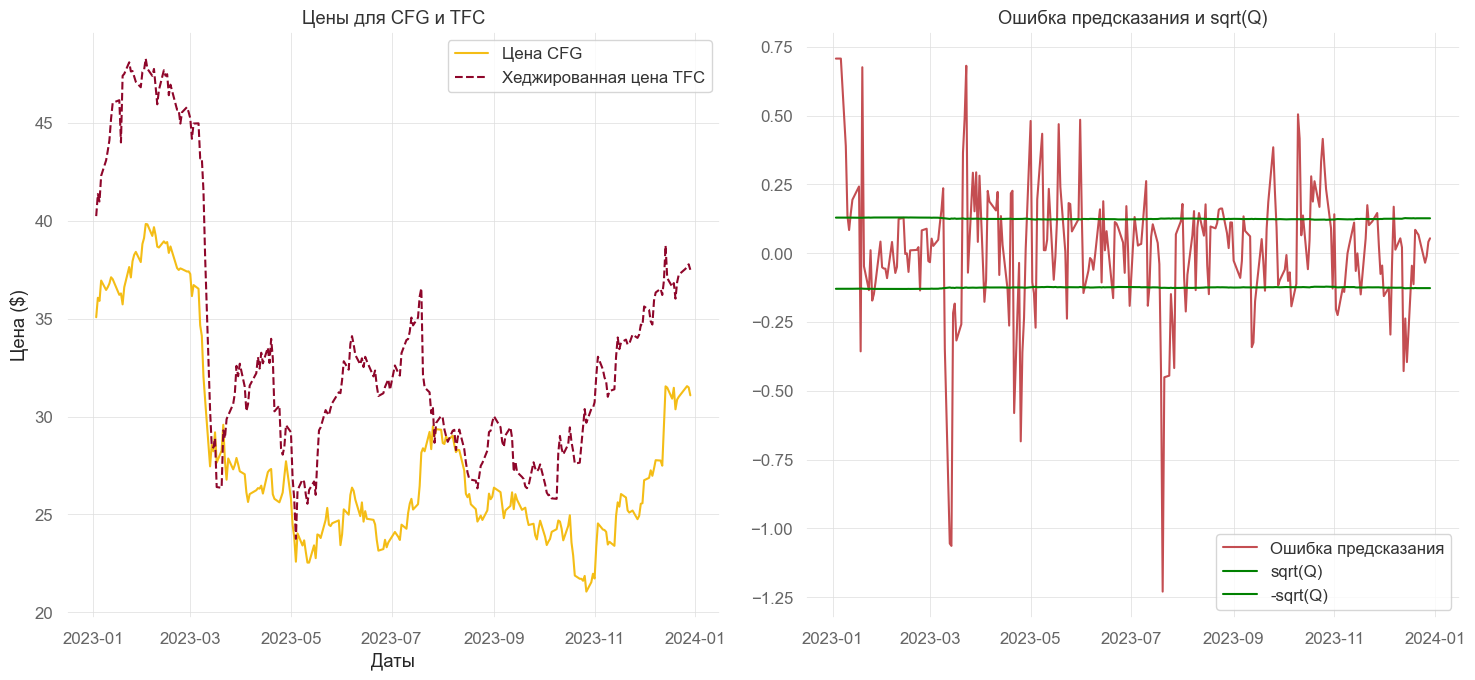

In [39]:
# TODO: Разобраться с этим, понять как обернуть в функцию для простоты тестирования и экспериментов
kf = KalmanFilter(dim_x=2, dim_z=1)
delta = 0.00001
Ve = 0.01

kf.Q = delta / (1 - delta) * np.eye(2)  # process noise
# kf.Q = Q_discrete_white_noise(2, dt=0.1, var=1., block_size=1)
kf.x = np.zeros(2)  # initial state
kf.P = np.zeros((2, 2))    # initial covariance
kf.F = np.eye(2)    # state transition matrix
kf.R = Ve        # observation noise
kf.H = None

def kalman_chan_calc(kf, row):
    x = row[ticker1]
    y = row[ticker2]
    kf.H = np.array([[x, 1.0]])  # observation matrix
    kf.predict()
    kf.update(y)

    hedge_ratio = kf.x[0]
    intercept = kf.x[1]

    yhat = np.dot([x, 1.0], kf.x)
    Q = np.sqrt(np.dot([x, 1.0], np.dot(kf.P, [x, 1.0])) + Ve)
    e = y - yhat

    return pd.Series([hedge_ratio, intercept, Q, e, yhat], index=['hedge', 'intercept', 'Q', 'e', 'yhat'])


training_set[['hedge', 'intercept', 'Q', 'e', 'yhat']] = training_set[[ticker1, ticker2]].apply(lambda row: kalman_chan_calc(kf, row), axis=1)

# first 2 measurements are not reliable
training_set.loc[training_set.index[0:3], 'hedge'] = training_set.loc[training_set.index[3], 'hedge']
training_set.loc[training_set.index[0:3], 'intercept'] = training_set.loc[training_set.index[3], 'intercept']
training_set.loc[training_set.index[0:3], 'Q'] = training_set.loc[training_set.index[3], 'Q']
training_set.loc[training_set.index[0:3], 'e'] = training_set.loc[training_set.index[3], 'e']
training_set.loc[training_set.index[0:3], 'yhat'] = training_set.loc[training_set.index[3], 'yhat']


hedged_prices = training_set['hedge'] * training_set[ticker2]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].plot(training_set[ticker1], lw=1.5, label=f"Цена {ticker1}",color="#F4BD16")
axes[0].plot(hedged_prices, lw=1.5, linestyle='--', label=f"Хеджированная цена {ticker2}",color="#8E062A")
axes[0].set_xlabel('Даты')
axes[0].set_ylabel('Цена ($)')
axes[0].set_title(f"Цены для {ticker1} и {ticker2}")
axes[0].grid(True)
axes[0].legend(loc=0)


axes[1].plot(training_set['e'], 'r', label='Ошибка предсказания')
axes[1].plot(training_set['Q'], label='sqrt(Q)', color='green')
axes[1].plot(-training_set['Q'], label='-sqrt(Q)', color='green')
axes[1].legend(loc=0)
axes[1].set_title('Ошибка предсказания и sqrt(Q)')

# This helps us tighten the figure margins
plt.tight_layout()
plt.show()


# Позиции
Расчитаем когда будем открывать позиции, а когда закрывать.

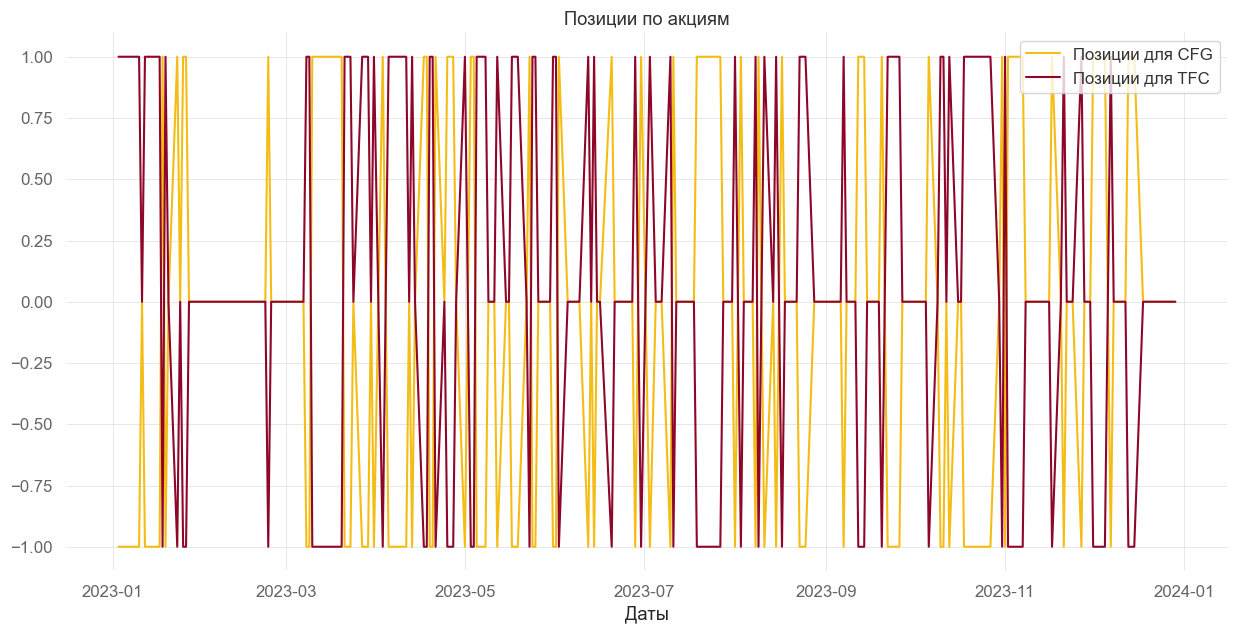

In [40]:
# longsEntry = e < -np.sqrt(Q)
# longsExit = e > -np.sqrt(Q)
# shortsEntry = e > np.sqrt(Q)
# shortsExit = e < np.sqrt(Q)

def long(row):
    if (row['e'] < -row['Q']):
        return pd.Series([1, -1]) # entry
    elif (row['e'] > -row['Q']):
        return pd.Series([0, 0]) #exit
    
    return pd.Series([np.nan, np.nan])

def short(row):
    if (row['e'] > row['Q']):
        return pd.Series([-1, 1]) # entry
    elif (row['e'] < row['Q']):
        return pd.Series([0, 0])
    
    return pd.Series([np.nan, np.nan])

positions_with_dates = calculate_positions_from_lambda(training_set, long, short)
positions_with_dates = positions_with_dates.rename(columns={'ticker1': ticker1, 'ticker2': ticker2})

plt.figure(figsize=(15, 7))
plt.plot(positions_with_dates[ticker1], lw=1.5, label=f'Позиции для {ticker1}',color="#F4BD16")
plt.plot(positions_with_dates[ticker2], lw=1.5, label=f'Позиции для {ticker2}',color="#8E062A")
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Даты')
plt.title('Позиции по акциям')
plt.show()

### PnL
Посчитаем теперь Profits and Loss для нашей стратегии. У нас есть массив позиций, с датами. Но есть с ним небольшая проблема, расчет был произведен по цене закрытия и потому мы не можем учитывать доходы в эту дату, ведь фактически, мы открываем позицию на следующее утро. Чтобы это учесть мы выполним операцию сдвига, которые все данные в массиве подвинит на один день: `positions.shift()`

После этого, мы считаем измененение цены день ко дню и перемножаем результаты с позициями, получая массив в котором указано сколько мы заработали за день.

In [41]:
dailyret = training_set.loc[:, (ticker1, ticker2)].pct_change()
pnl = (np.array(positions_with_dates.shift()) * np.array(dailyret)).sum(axis=1)

pnl_with_dates = (positions_with_dates.shift() * dailyret).sum(axis=1)
sharpe_ration = np.sqrt(252) * pnl[1:].mean() / pnl[1:].std()
cummulative_pnl = np.cumprod(1 + pnl_with_dates) - 1
print(f"Sharpe Ratio: {sharpe_ration:.2f}")
print(f"Cummulative PnL: {cummulative_pnl.iloc[-1]:.2f}")

Sharpe Ratio: -0.09
Cummulative PnL: -0.04


                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2024-12-31
Risk-Free Rate             0.0%
Time in Market             32.0%

Cumulative Return          -15.76%
CAGR﹪                     -11.19%

Sharpe                     -1.47
Prob. Sharpe Ratio         6.65%
Smart Sharpe               -1.21
Sortino                    -1.82
Smart Sortino              -1.5
Sortino/√2                 -1.29
Smart Sortino/√2           -1.06
Omega                      0.64

Max Drawdown               -17.04%
Max DD Date                2024-12-13
Max DD Period Start        2024-01-16
Max DD Period End          2024-12-31
Longest DD Days            351
Volatility (ann.)          11.25%
Calmar                     -0.66
Skew                       -0.71
Kurtosis                   8.36

Expected Daily %           -0.07%
Expected Monthly %         -1.42%
Expected Yearly %          -15.76%
Kelly Criterion            -24.16%


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-01-16,2024-12-13,2024-12-31,351,-17.036914,-16.893282


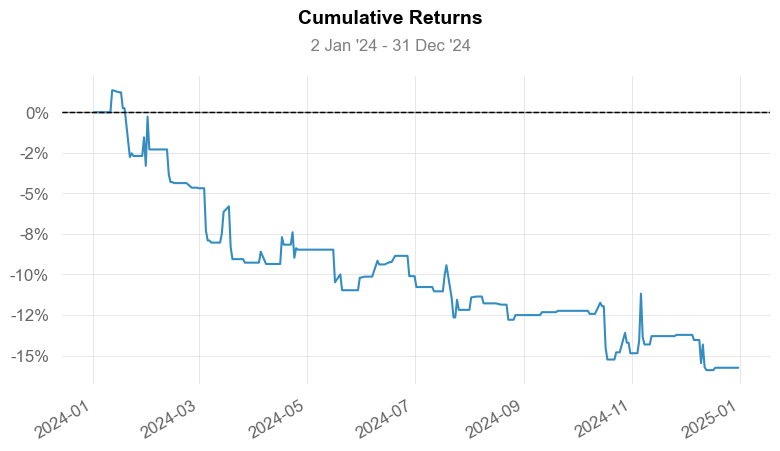

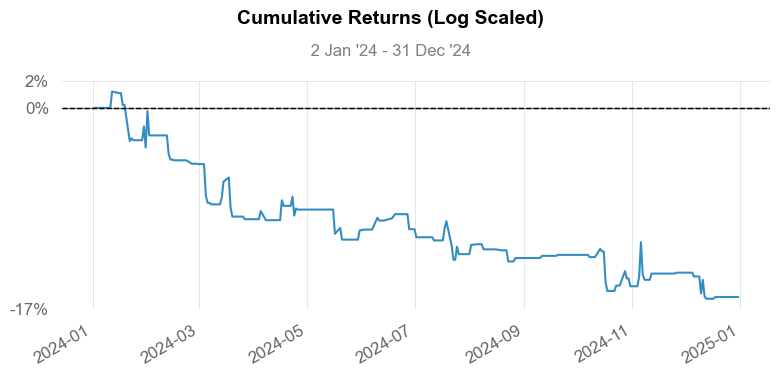

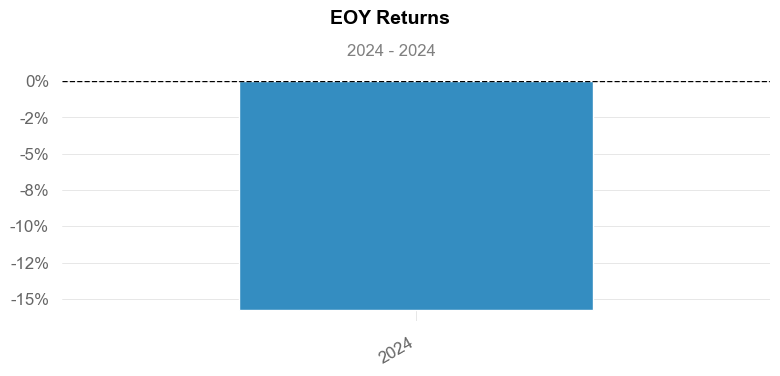

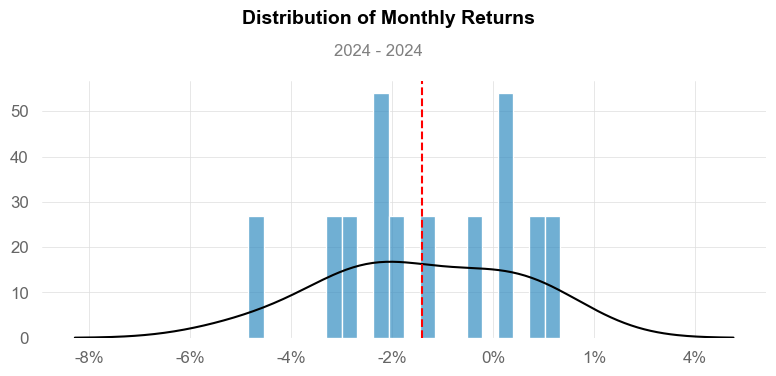

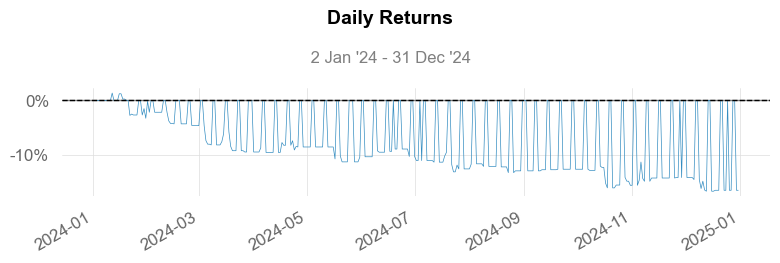

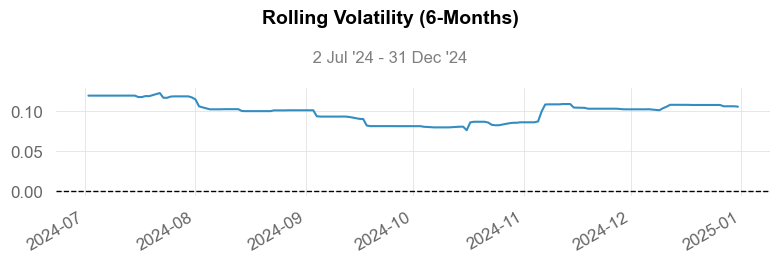

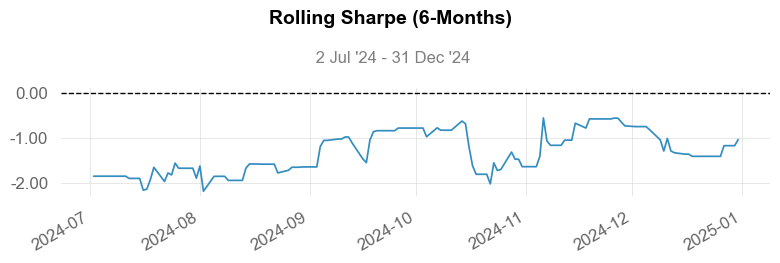

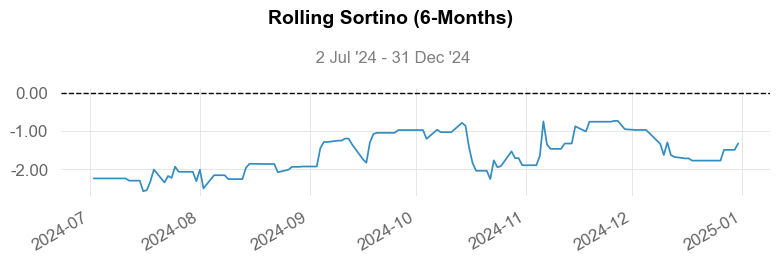

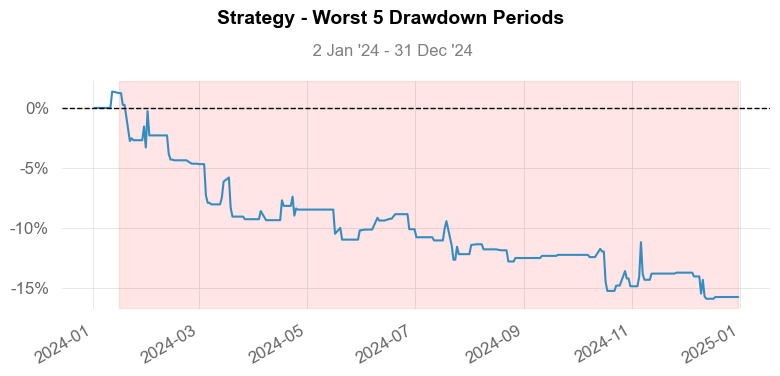

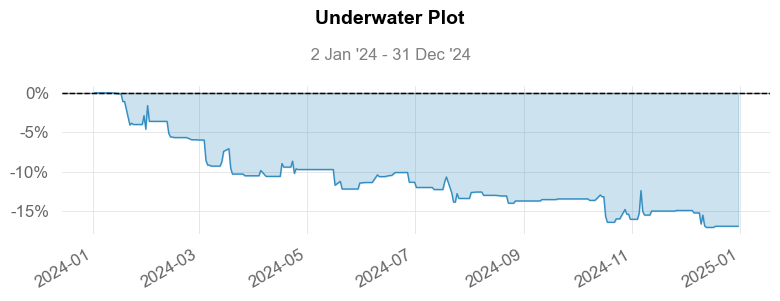

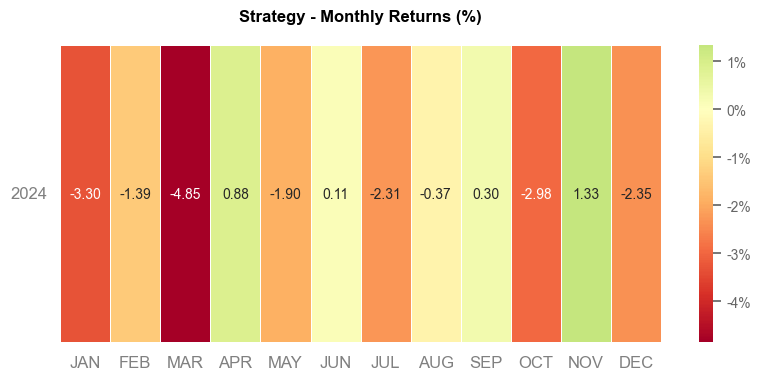

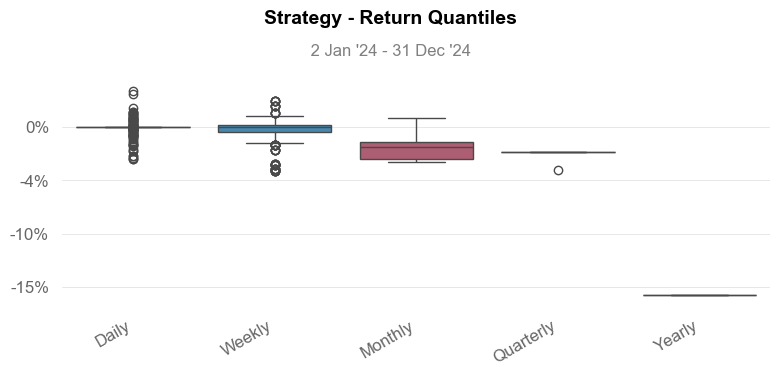

In [42]:
sample_set[['hedge', 'intercept', 'Q', 'e', 'yhat']] = sample_set[[ticker1, ticker2]].apply(lambda row: kalman_chan_calc(kf, row), axis=1)

# first 2 measurements are not reliable
sample_set.loc[sample_set.index[0:3], 'hedge'] = sample_set.loc[sample_set.index[3], 'hedge']
sample_set.loc[sample_set.index[0:3], 'intercept'] = sample_set.loc[sample_set.index[3], 'intercept']
sample_set.loc[sample_set.index[0:3], 'Q'] = sample_set.loc[sample_set.index[3], 'Q']
sample_set.loc[sample_set.index[0:3], 'e'] = sample_set.loc[sample_set.index[3], 'e']
sample_set.loc[sample_set.index[0:3], 'yhat'] = sample_set.loc[sample_set.index[3], 'yhat']


positions_with_dates = calculate_positions_from_lambda(sample_set, long, short)
positions_with_dates = positions_with_dates.rename(columns={'ticker1': ticker1, 'ticker2': ticker2})


dailyret = sample_set.loc[:, (ticker1, ticker2)].pct_change()
pnl = (np.array(positions_with_dates.shift()) * np.array(dailyret)).sum(axis=1)

pnl_with_dates = (positions_with_dates.shift() * dailyret).sum(axis=1)

qs.reports.full(
    pnl_with_dates,
    title=f"Отчет по паре {ticker1} и {ticker2}",
)